# Imports

In [1]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration's

In [2]:
# =====================
# CONFIGURATION
# =====================
config = {
    "model": "wavelet",   # Options: mobilenetv2, convnext, dct, stft, wavelet, learnable_freq
    "epochs": 60,
    "batch_size": 32,
    "lr": 1e-3,
    "early_stopping_patience": 7,
    "dropout": 0.4,
    "num_classes": 5,  # update based on dataset
    "train_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\train",
    "val_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\val",
    "test_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\test",
}
config["save_dir"] = os.path.join("models", config["model"])
os.makedirs(config["save_dir"], exist_ok=True)

config["model_path_auc"] = os.path.join(config["save_dir"], "best_auc.pth")
config["model_path_loss"] = os.path.join(config["save_dir"], "best_loss.pth")
print(f"Models will be saved in: {config['model_path_auc']}")
print(f"Models will be saved in: {config['model_path_loss']}")

Models will be saved in: models\wavelet\best_auc.pth
Models will be saved in: models\wavelet\best_loss.pth


# Transformation and DataLoader

In [3]:
# =====================
# DATA PIPELINE
# =====================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(config["train_dir"], transform=transform)
val_data = datasets.ImageFolder(config["val_dir"], transform=transform)
test_data = datasets.ImageFolder(config["test_dir"], transform=transform)

train_loader = DataLoader(train_data, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_data, batch_size=config["batch_size"], shuffle=False)
test_loader = DataLoader(test_data, batch_size=config["batch_size"], shuffle=False)

# =====================
# DEVICE
# =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}" + (f" - {torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else ""))

Using device: cuda - NVIDIA GeForce RTX 3050 Laptop GPU


# Model Builder

In [4]:
# =====================
# MODEL BUILDER
# =====================
class ClassifierHead(nn.Module):
    def __init__(self, in_features, num_classes, dropout=0.5):
        super().__init__()
        self.fc = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Dropout(dropout),
            nn.Linear(in_features, num_classes)
        )
    def forward(self, x):
        return self.fc(x)

def build_model(config):
    if config["model"] == "mobilenetv2":
        base = models.mobilenet_v2(weights="IMAGENET1K_V1")
        in_features = base.classifier[1].in_features
        base.classifier = ClassifierHead(in_features, config["num_classes"], config["dropout"])
        return base

    elif config["model"] == "convnext":
        base = models.convnext_tiny(weights="IMAGENET1K_V1")
        in_features = base.classifier[2].in_features
        base.classifier[2] = nn.Linear(in_features, config["num_classes"])
        return base

    elif config["model"] == "dct":
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(224*224*3, 512),
            nn.ReLU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(512, config["num_classes"])
        )

    elif config["model"] == "stft":
        return nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(16, config["num_classes"])
        )

    elif config["model"] == "wavelet":
        return nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, config["num_classes"])
        )

    elif config["model"] == "learnable_freq":
        return nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, config["num_classes"])
        )

    else:
        raise ValueError(f"Unknown model type: {config['model']}")

model = build_model(config).to(device)

# =====================
# TRAINING SETUP
# =====================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["lr"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

# Helper Function's

In [5]:
# =====================
# HELPER FUNCTIONS
# =====================
def compute_metrics(y_true, y_pred, y_prob, average="macro"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_prob, multi_class="ovr")
    except:
        auc = 0.0
    return acc, prec, rec, f1, auc

# Training and Validation

In [6]:
best_val_loss = np.inf
best_val_auc = -np.inf
patience_counter = 0

# For tracking
history = {
    "train_loss": [], "val_loss": [],
    "train_acc": [], "val_acc": [],
    "train_prec": [], "val_prec": [],
    "train_rec": [], "val_rec": [],
    "train_f1": [], "val_f1": [],
    "train_auc": [], "val_auc": []
}

# Adding SEED 
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# =====================
# TRAINING LOOP
# =====================
for epoch in range(config["epochs"]):
    # -------- TRAIN --------
    model.train()
    train_loss, train_preds, train_labels, train_probs = 0, [], [], []
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        probs = torch.softmax(preds, dim=1)
        train_preds.extend(torch.argmax(preds, 1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
        train_probs.extend(probs.cpu().detach().numpy())

    train_loss /= len(train_loader)
    train_acc, train_prec, train_rec, train_f1, train_auc = compute_metrics(
        train_labels, train_preds, train_probs
    )

    # -------- VALIDATION --------
    model.eval()
    val_loss, val_preds, val_labels, val_probs = 0, [], [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Val]"):
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            loss = criterion(preds, labels)
            val_loss += loss.item()
            probs = torch.softmax(preds, dim=1)
            val_preds.extend(torch.argmax(preds, 1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_probs.extend(probs.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc, val_prec, val_rec, val_f1, val_auc = compute_metrics(
        val_labels, val_preds, val_probs
    )

    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["train_prec"].append(train_prec)
    history["val_prec"].append(val_prec)
    history["train_rec"].append(train_rec)
    history["val_rec"].append(val_rec)
    history["train_f1"].append(train_f1)
    history["val_f1"].append(val_f1)
    history["train_auc"].append(train_auc)
    history["val_auc"].append(val_auc)

    # Print results like your screenshot
    print(f"\nEpoch {epoch+1}:")
    print(f" Train -> Loss={train_loss:.4f}, Acc={train_acc:.4f}, Prec={train_prec:.4f}, "
          f"Rec={train_rec:.4f}, F1={train_f1:.4f}, AUC={train_auc:.4f}")
    print(f" Val   -> Loss={val_loss:.4f}, Acc={val_acc:.4f}, Prec={val_prec:.4f}, "
          f"Rec={val_rec:.4f}, F1={val_f1:.4f}, AUC={val_auc:.4f}")

    # Save best model based on AUC
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        patience_counter = 0
        torch.save(model.state_dict(), config["model_path_auc"])
        print(f"Best model (AUC) saved with AUC = {best_val_auc:.4f}")
    else:
        print(f"Validation AUC {val_auc:.4f} did not improve from {best_val_auc:.4f}")

    # Save best model based on Loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), config["model_path_loss"])
        print(f"Best model (Loss) saved with Loss = {best_val_loss:.4f}")
    else:
        print(f"Validation Loss {val_loss:.4f} did not reduced from {best_val_loss:.4f}")

    # Early stopping (based on AUC)
    if val_auc <= best_val_auc:
        patience_counter += 1
        if patience_counter >= config["early_stopping_patience"]:
            print("Early stopping triggered!")
            break


Epoch 1/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.92it/s]



Epoch 1:
 Train -> Loss=1.1976, Acc=0.6148, Prec=0.1230, Rec=0.2000, F1=0.1523, AUC=0.5291
 Val   -> Loss=1.1767, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5475
Best model (AUC) saved with AUC = 0.5475
Best model (Loss) saved with Loss = 1.1767


Epoch 2/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.44it/s]



Epoch 2:
 Train -> Loss=1.1798, Acc=0.6148, Prec=0.1230, Rec=0.2000, F1=0.1523, AUC=0.5425
 Val   -> Loss=1.1742, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5720
Best model (AUC) saved with AUC = 0.5720
Best model (Loss) saved with Loss = 1.1742


Epoch 3/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.24it/s]



Epoch 3:
 Train -> Loss=1.1764, Acc=0.6148, Prec=0.1230, Rec=0.2000, F1=0.1523, AUC=0.5576
 Val   -> Loss=1.1686, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5875
Best model (AUC) saved with AUC = 0.5875
Best model (Loss) saved with Loss = 1.1686


Epoch 4/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.92it/s]



Epoch 4:
 Train -> Loss=1.1708, Acc=0.6148, Prec=0.1230, Rec=0.2000, F1=0.1523, AUC=0.5711
 Val   -> Loss=1.1587, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.6026
Best model (AUC) saved with AUC = 0.6026
Best model (Loss) saved with Loss = 1.1587


Epoch 5/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.05it/s]



Epoch 5:
 Train -> Loss=1.1646, Acc=0.6148, Prec=0.1230, Rec=0.2000, F1=0.1523, AUC=0.5853
 Val   -> Loss=1.1556, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.6154
Best model (AUC) saved with AUC = 0.6154
Best model (Loss) saved with Loss = 1.1556


Epoch 6/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.37it/s]



Epoch 6:
 Train -> Loss=1.1595, Acc=0.6149, Prec=0.3230, Rec=0.2003, F1=0.1529, AUC=0.6011
 Val   -> Loss=1.1474, Acc=0.6161, Prec=0.2565, Rec=0.2015, F1=0.1554, AUC=0.6331
Best model (AUC) saved with AUC = 0.6331
Best model (Loss) saved with Loss = 1.1474


Epoch 7/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.29it/s]



Epoch 7:
 Train -> Loss=1.1525, Acc=0.6152, Prec=0.1968, Rec=0.2010, F1=0.1545, AUC=0.6160
 Val   -> Loss=1.1475, Acc=0.6168, Prec=0.1963, Rec=0.2029, F1=0.1584, AUC=0.6445
Best model (AUC) saved with AUC = 0.6445
Validation Loss 1.1475 did not reduced from 1.1474


Epoch 8/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.31it/s]



Epoch 8:
 Train -> Loss=1.1465, Acc=0.6157, Prec=0.2180, Rec=0.2026, F1=0.1579, AUC=0.6255
 Val   -> Loss=1.1328, Acc=0.6172, Prec=0.1951, Rec=0.2036, F1=0.1598, AUC=0.6585
Best model (AUC) saved with AUC = 0.6585
Best model (Loss) saved with Loss = 1.1328


Epoch 9/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.44it/s]



Epoch 9:
 Train -> Loss=1.1395, Acc=0.6165, Prec=0.2017, Rec=0.2047, F1=0.1621, AUC=0.6418
 Val   -> Loss=1.1291, Acc=0.6187, Prec=0.2138, Rec=0.2090, F1=0.1702, AUC=0.6648
Best model (AUC) saved with AUC = 0.6648
Best model (Loss) saved with Loss = 1.1291


Epoch 10/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.89it/s]



Epoch 10:
 Train -> Loss=1.1357, Acc=0.6169, Prec=0.1929, Rec=0.2058, F1=0.1641, AUC=0.6506
 Val   -> Loss=1.1207, Acc=0.6187, Prec=0.2192, Rec=0.2072, F1=0.1666, AUC=0.6745
Best model (AUC) saved with AUC = 0.6745
Best model (Loss) saved with Loss = 1.1207


Epoch 11/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.39it/s]



Epoch 11:
 Train -> Loss=1.1299, Acc=0.6169, Prec=0.1934, Rec=0.2072, F1=0.1669, AUC=0.6568
 Val   -> Loss=1.1180, Acc=0.6220, Prec=0.2226, Rec=0.2156, F1=0.1812, AUC=0.6774
Best model (AUC) saved with AUC = 0.6774
Best model (Loss) saved with Loss = 1.1180


Epoch 12/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.21it/s]



Epoch 12:
 Train -> Loss=1.1256, Acc=0.6175, Prec=0.1906, Rec=0.2083, F1=0.1688, AUC=0.6635
 Val   -> Loss=1.1158, Acc=0.6194, Prec=0.2207, Rec=0.2099, F1=0.1716, AUC=0.6812
Best model (AUC) saved with AUC = 0.6812
Best model (Loss) saved with Loss = 1.1158


Epoch 13/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.55it/s]



Epoch 13:
 Train -> Loss=1.1218, Acc=0.6181, Prec=0.1922, Rec=0.2101, F1=0.1719, AUC=0.6651
 Val   -> Loss=1.1061, Acc=0.6202, Prec=0.2164, Rec=0.2119, F1=0.1752, AUC=0.6861
Best model (AUC) saved with AUC = 0.6861
Best model (Loss) saved with Loss = 1.1061


Epoch 14/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.50it/s]



Epoch 14:
 Train -> Loss=1.1163, Acc=0.6187, Prec=0.1940, Rec=0.2117, F1=0.1746, AUC=0.6722
 Val   -> Loss=1.1024, Acc=0.6228, Prec=0.2271, Rec=0.2170, F1=0.1836, AUC=0.6901
Best model (AUC) saved with AUC = 0.6901
Best model (Loss) saved with Loss = 1.1024


Epoch 15/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.90it/s]



Epoch 15:
 Train -> Loss=1.1112, Acc=0.6195, Prec=0.3940, Rec=0.2134, F1=0.1774, AUC=0.6777
 Val   -> Loss=1.0981, Acc=0.6224, Prec=0.2773, Rec=0.2170, F1=0.1842, AUC=0.6922
Best model (AUC) saved with AUC = 0.6922
Best model (Loss) saved with Loss = 1.0981


Epoch 16/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.51it/s]



Epoch 16:
 Train -> Loss=1.1083, Acc=0.6200, Prec=0.1966, Rec=0.2149, F1=0.1796, AUC=0.6798
 Val   -> Loss=1.0962, Acc=0.6209, Prec=0.2482, Rec=0.2141, F1=0.1793, AUC=0.6938
Best model (AUC) saved with AUC = 0.6938
Best model (Loss) saved with Loss = 1.0962


Epoch 17/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.66it/s]



Epoch 17:
 Train -> Loss=1.1053, Acc=0.6200, Prec=0.1938, Rec=0.2155, F1=0.1805, AUC=0.6841
 Val   -> Loss=1.0941, Acc=0.6250, Prec=0.2227, Rec=0.2226, F1=0.1918, AUC=0.6955
Best model (AUC) saved with AUC = 0.6955
Best model (Loss) saved with Loss = 1.0941


Epoch 18/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.29it/s]



Epoch 18:
 Train -> Loss=1.1002, Acc=0.6203, Prec=0.1945, Rec=0.2159, F1=0.1810, AUC=0.6866
 Val   -> Loss=1.0871, Acc=0.6257, Prec=0.2184, Rec=0.2253, F1=0.1953, AUC=0.6985
Best model (AUC) saved with AUC = 0.6985
Best model (Loss) saved with Loss = 1.0871


Epoch 19/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.35it/s]



Epoch 19:
 Train -> Loss=1.0988, Acc=0.6212, Prec=0.1944, Rec=0.2177, F1=0.1836, AUC=0.6892
 Val   -> Loss=1.0832, Acc=0.6280, Prec=0.2222, Rec=0.2303, F1=0.2020, AUC=0.6996
Best model (AUC) saved with AUC = 0.6996
Best model (Loss) saved with Loss = 1.0832


Epoch 20/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.28it/s]



Epoch 20:
 Train -> Loss=1.0944, Acc=0.6209, Prec=0.2325, Rec=0.2185, F1=0.1851, AUC=0.6912
 Val   -> Loss=1.0862, Acc=0.6291, Prec=0.2164, Rec=0.2361, F1=0.2084, AUC=0.7009
Best model (AUC) saved with AUC = 0.7009
Validation Loss 1.0862 did not reduced from 1.0832


Epoch 21/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.54it/s]



Epoch 21:
 Train -> Loss=1.0914, Acc=0.6208, Prec=0.2591, Rec=0.2187, F1=0.1852, AUC=0.6940
 Val   -> Loss=1.0783, Acc=0.6272, Prec=0.2895, Rec=0.2303, F1=0.2041, AUC=0.7023
Best model (AUC) saved with AUC = 0.7023
Best model (Loss) saved with Loss = 1.0783


Epoch 22/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.55it/s]



Epoch 22:
 Train -> Loss=1.0916, Acc=0.6215, Prec=0.2335, Rec=0.2202, F1=0.1875, AUC=0.6915
 Val   -> Loss=1.0793, Acc=0.6265, Prec=0.2770, Rec=0.2295, F1=0.2039, AUC=0.7033
Best model (AUC) saved with AUC = 0.7033
Validation Loss 1.0793 did not reduced from 1.0783


Epoch 23/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.56it/s]



Epoch 23:
 Train -> Loss=1.0884, Acc=0.6213, Prec=0.2964, Rec=0.2213, F1=0.1892, AUC=0.6963
 Val   -> Loss=1.0805, Acc=0.6295, Prec=0.3156, Rec=0.2370, F1=0.2105, AUC=0.7048
Best model (AUC) saved with AUC = 0.7048
Validation Loss 1.0805 did not reduced from 1.0783


Epoch 24/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.38it/s]



Epoch 24:
 Train -> Loss=1.0864, Acc=0.6223, Prec=0.2163, Rec=0.2215, F1=0.1892, AUC=0.6968
 Val   -> Loss=1.0721, Acc=0.6265, Prec=0.2805, Rec=0.2308, F1=0.2056, AUC=0.7051
Best model (AUC) saved with AUC = 0.7051
Best model (Loss) saved with Loss = 1.0721


Epoch 25/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.61it/s]



Epoch 25:
 Train -> Loss=1.0840, Acc=0.6215, Prec=0.2836, Rec=0.2219, F1=0.1898, AUC=0.6986
 Val   -> Loss=1.0728, Acc=0.6280, Prec=0.2622, Rec=0.2341, F1=0.2069, AUC=0.7070
Best model (AUC) saved with AUC = 0.7070
Validation Loss 1.0728 did not reduced from 1.0721


Epoch 26/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.59it/s]



Epoch 26:
 Train -> Loss=1.0820, Acc=0.6214, Prec=0.2272, Rec=0.2220, F1=0.1902, AUC=0.6988
 Val   -> Loss=1.0693, Acc=0.6276, Prec=0.2992, Rec=0.2323, F1=0.2079, AUC=0.7074
Best model (AUC) saved with AUC = 0.7074
Best model (Loss) saved with Loss = 1.0693


Epoch 27/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.32it/s]



Epoch 27:
 Train -> Loss=1.0789, Acc=0.6221, Prec=0.2305, Rec=0.2225, F1=0.1907, AUC=0.7015
 Val   -> Loss=1.0665, Acc=0.6280, Prec=0.2637, Rec=0.2341, F1=0.2071, AUC=0.7086
Best model (AUC) saved with AUC = 0.7086
Best model (Loss) saved with Loss = 1.0665


Epoch 28/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.24it/s]



Epoch 28:
 Train -> Loss=1.0770, Acc=0.6226, Prec=0.2545, Rec=0.2238, F1=0.1926, AUC=0.7023
 Val   -> Loss=1.0735, Acc=0.6310, Prec=0.3908, Rec=0.2423, F1=0.2200, AUC=0.7094
Best model (AUC) saved with AUC = 0.7094
Validation Loss 1.0735 did not reduced from 1.0665


Epoch 29/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.14it/s]



Epoch 29:
 Train -> Loss=1.0775, Acc=0.6221, Prec=0.2245, Rec=0.2239, F1=0.1927, AUC=0.7022
 Val   -> Loss=1.0665, Acc=0.6291, Prec=0.3582, Rec=0.2366, F1=0.2130, AUC=0.7100
Best model (AUC) saved with AUC = 0.7100
Validation Loss 1.0665 did not reduced from 1.0665


Epoch 30/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.64it/s]



Epoch 30:
 Train -> Loss=1.0754, Acc=0.6227, Prec=0.2344, Rec=0.2246, F1=0.1934, AUC=0.7014
 Val   -> Loss=1.0623, Acc=0.6287, Prec=0.2912, Rec=0.2370, F1=0.2129, AUC=0.7117
Best model (AUC) saved with AUC = 0.7117
Best model (Loss) saved with Loss = 1.0623


Epoch 31/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.90it/s]



Epoch 31:
 Train -> Loss=1.0743, Acc=0.6235, Prec=0.2588, Rec=0.2275, F1=0.1980, AUC=0.7050
 Val   -> Loss=1.0622, Acc=0.6287, Prec=0.3542, Rec=0.2349, F1=0.2104, AUC=0.7117
Validation AUC 0.7117 did not improve from 0.7117
Best model (Loss) saved with Loss = 1.0622


Epoch 32/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.89it/s]



Epoch 32:
 Train -> Loss=1.0712, Acc=0.6236, Prec=0.2294, Rec=0.2269, F1=0.1968, AUC=0.7050
 Val   -> Loss=1.0601, Acc=0.6310, Prec=0.3988, Rec=0.2397, F1=0.2168, AUC=0.7131
Best model (AUC) saved with AUC = 0.7131
Best model (Loss) saved with Loss = 1.0601


Epoch 33/60 [Val]: 100%|██████████| 84/84 [00:22<00:00,  3.77it/s]



Epoch 33:
 Train -> Loss=1.0705, Acc=0.6239, Prec=0.2545, Rec=0.2283, F1=0.1986, AUC=0.7067
 Val   -> Loss=1.0609, Acc=0.6276, Prec=0.3791, Rec=0.2320, F1=0.2095, AUC=0.7127
Validation AUC 0.7127 did not improve from 0.7131
Validation Loss 1.0609 did not reduced from 1.0601


Epoch 34/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.05it/s]



Epoch 34:
 Train -> Loss=1.0705, Acc=0.6235, Prec=0.3003, Rec=0.2278, F1=0.1989, AUC=0.7060
 Val   -> Loss=1.0613, Acc=0.6295, Prec=0.3009, Rec=0.2360, F1=0.2126, AUC=0.7137
Best model (AUC) saved with AUC = 0.7137
Validation Loss 1.0613 did not reduced from 1.0601


Epoch 35/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.01it/s]



Epoch 35:
 Train -> Loss=1.0699, Acc=0.6234, Prec=0.2535, Rec=0.2263, F1=0.1965, AUC=0.7079
 Val   -> Loss=1.0715, Acc=0.6332, Prec=0.3583, Rec=0.2538, F1=0.2331, AUC=0.7151
Best model (AUC) saved with AUC = 0.7151
Validation Loss 1.0715 did not reduced from 1.0601


Epoch 36/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.93it/s]



Epoch 36:
 Train -> Loss=1.0660, Acc=0.6256, Prec=0.2831, Rec=0.2306, F1=0.2015, AUC=0.7092
 Val   -> Loss=1.0554, Acc=0.6291, Prec=0.3902, Rec=0.2370, F1=0.2133, AUC=0.7156
Best model (AUC) saved with AUC = 0.7156
Best model (Loss) saved with Loss = 1.0554


Epoch 37/60 [Val]: 100%|██████████| 84/84 [00:22<00:00,  3.70it/s]



Epoch 37:
 Train -> Loss=1.0660, Acc=0.6247, Prec=0.2910, Rec=0.2301, F1=0.2015, AUC=0.7095
 Val   -> Loss=1.0558, Acc=0.6321, Prec=0.3396, Rec=0.2473, F1=0.2247, AUC=0.7171
Best model (AUC) saved with AUC = 0.7171
Validation Loss 1.0558 did not reduced from 1.0554


Epoch 38/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.94it/s]



Epoch 38:
 Train -> Loss=1.0662, Acc=0.6249, Prec=0.2809, Rec=0.2323, F1=0.2046, AUC=0.7094
 Val   -> Loss=1.0630, Acc=0.6332, Prec=0.3270, Rec=0.2507, F1=0.2293, AUC=0.7166
Validation AUC 0.7166 did not improve from 0.7171
Validation Loss 1.0630 did not reduced from 1.0554


Epoch 39/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.95it/s]



Epoch 39:
 Train -> Loss=1.0656, Acc=0.6257, Prec=0.2963, Rec=0.2324, F1=0.2044, AUC=0.7104
 Val   -> Loss=1.0563, Acc=0.6317, Prec=0.3362, Rec=0.2478, F1=0.2326, AUC=0.7192
Best model (AUC) saved with AUC = 0.7192
Validation Loss 1.0563 did not reduced from 1.0554


Epoch 40/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.90it/s]



Epoch 40:
 Train -> Loss=1.0635, Acc=0.6262, Prec=0.3166, Rec=0.2338, F1=0.2076, AUC=0.7106
 Val   -> Loss=1.0540, Acc=0.6313, Prec=0.4086, Rec=0.2397, F1=0.2193, AUC=0.7169
Validation AUC 0.7169 did not improve from 0.7192
Best model (Loss) saved with Loss = 1.0540


Epoch 41/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.08it/s]



Epoch 41:
 Train -> Loss=1.0646, Acc=0.6248, Prec=0.2791, Rec=0.2305, F1=0.2017, AUC=0.7112
 Val   -> Loss=1.0516, Acc=0.6343, Prec=0.4035, Rec=0.2491, F1=0.2284, AUC=0.7191
Validation AUC 0.7191 did not improve from 0.7192
Best model (Loss) saved with Loss = 1.0516


Epoch 42/60 [Val]: 100%|██████████| 84/84 [00:22<00:00,  3.68it/s]



Epoch 42:
 Train -> Loss=1.0629, Acc=0.6251, Prec=0.2773, Rec=0.2317, F1=0.2027, AUC=0.7124
 Val   -> Loss=1.0568, Acc=0.6343, Prec=0.3937, Rec=0.2524, F1=0.2300, AUC=0.7198
Best model (AUC) saved with AUC = 0.7198
Validation Loss 1.0568 did not reduced from 1.0516


Epoch 43/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.43it/s]



Epoch 43:
 Train -> Loss=1.0607, Acc=0.6261, Prec=0.2989, Rec=0.2344, F1=0.2070, AUC=0.7131
 Val   -> Loss=1.0522, Acc=0.6324, Prec=0.4374, Rec=0.2512, F1=0.2290, AUC=0.7214
Best model (AUC) saved with AUC = 0.7214
Validation Loss 1.0522 did not reduced from 1.0516


Epoch 44/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.59it/s]



Epoch 44:
 Train -> Loss=1.0601, Acc=0.6270, Prec=0.3360, Rec=0.2362, F1=0.2105, AUC=0.7130
 Val   -> Loss=1.0477, Acc=0.6317, Prec=0.3477, Rec=0.2474, F1=0.2303, AUC=0.7223
Best model (AUC) saved with AUC = 0.7223
Best model (Loss) saved with Loss = 1.0477


Epoch 45/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.38it/s]



Epoch 45:
 Train -> Loss=1.0598, Acc=0.6269, Prec=0.3161, Rec=0.2362, F1=0.2107, AUC=0.7146
 Val   -> Loss=1.0478, Acc=0.6347, Prec=0.4199, Rec=0.2517, F1=0.2321, AUC=0.7220
Validation AUC 0.7220 did not improve from 0.7223
Validation Loss 1.0478 did not reduced from 1.0477


Epoch 46/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.63it/s]



Epoch 46:
 Train -> Loss=1.0575, Acc=0.6263, Prec=0.3164, Rec=0.2358, F1=0.2093, AUC=0.7154
 Val   -> Loss=1.0467, Acc=0.6354, Prec=0.4187, Rec=0.2519, F1=0.2335, AUC=0.7223
Validation AUC 0.7223 did not improve from 0.7223
Best model (Loss) saved with Loss = 1.0467


Epoch 47/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.62it/s]



Epoch 47:
 Train -> Loss=1.0573, Acc=0.6266, Prec=0.3249, Rec=0.2364, F1=0.2107, AUC=0.7165
 Val   -> Loss=1.0498, Acc=0.6358, Prec=0.3808, Rec=0.2552, F1=0.2411, AUC=0.7230
Best model (AUC) saved with AUC = 0.7230
Validation Loss 1.0498 did not reduced from 1.0467


Epoch 48/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.22it/s]



Epoch 48:
 Train -> Loss=1.0558, Acc=0.6266, Prec=0.3153, Rec=0.2360, F1=0.2113, AUC=0.7176
 Val   -> Loss=1.0504, Acc=0.6362, Prec=0.4090, Rec=0.2581, F1=0.2382, AUC=0.7241
Best model (AUC) saved with AUC = 0.7241
Validation Loss 1.0504 did not reduced from 1.0467


Epoch 49/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.41it/s]



Epoch 49:
 Train -> Loss=1.0561, Acc=0.6274, Prec=0.3395, Rec=0.2386, F1=0.2155, AUC=0.7167
 Val   -> Loss=1.0465, Acc=0.6358, Prec=0.4229, Rec=0.2549, F1=0.2366, AUC=0.7245
Best model (AUC) saved with AUC = 0.7245
Best model (Loss) saved with Loss = 1.0465


Epoch 50/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.51it/s]



Epoch 50:
 Train -> Loss=1.0570, Acc=0.6280, Prec=0.3456, Rec=0.2398, F1=0.2159, AUC=0.7166
 Val   -> Loss=1.0433, Acc=0.6332, Prec=0.3533, Rec=0.2506, F1=0.2308, AUC=0.7260
Best model (AUC) saved with AUC = 0.7260
Best model (Loss) saved with Loss = 1.0433


Epoch 51/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.57it/s]



Epoch 51:
 Train -> Loss=1.0569, Acc=0.6267, Prec=0.3231, Rec=0.2392, F1=0.2167, AUC=0.7165
 Val   -> Loss=1.0516, Acc=0.6369, Prec=0.4042, Rec=0.2688, F1=0.2492, AUC=0.7265
Best model (AUC) saved with AUC = 0.7265
Validation Loss 1.0516 did not reduced from 1.0433


Epoch 52/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.25it/s]



Epoch 52:
 Train -> Loss=1.0518, Acc=0.6274, Prec=0.3315, Rec=0.2387, F1=0.2137, AUC=0.7211
 Val   -> Loss=1.0554, Acc=0.6302, Prec=0.4160, Rec=0.2462, F1=0.2310, AUC=0.7246
Validation AUC 0.7246 did not improve from 0.7265
Validation Loss 1.0554 did not reduced from 1.0433


Epoch 53/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.56it/s]



Epoch 53:
 Train -> Loss=1.0533, Acc=0.6267, Prec=0.2958, Rec=0.2387, F1=0.2147, AUC=0.7202
 Val   -> Loss=1.0429, Acc=0.6339, Prec=0.3843, Rec=0.2489, F1=0.2256, AUC=0.7261
Validation AUC 0.7261 did not improve from 0.7265
Best model (Loss) saved with Loss = 1.0429


Epoch 54/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.38it/s]



Epoch 54:
 Train -> Loss=1.0512, Acc=0.6275, Prec=0.3073, Rec=0.2370, F1=0.2123, AUC=0.7215
 Val   -> Loss=1.0413, Acc=0.6321, Prec=0.4190, Rec=0.2452, F1=0.2258, AUC=0.7272
Best model (AUC) saved with AUC = 0.7272
Best model (Loss) saved with Loss = 1.0413


Epoch 55/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.10it/s]



Epoch 55:
 Train -> Loss=1.0522, Acc=0.6278, Prec=0.3344, Rec=0.2403, F1=0.2182, AUC=0.7191
 Val   -> Loss=1.0413, Acc=0.6347, Prec=0.3626, Rec=0.2573, F1=0.2458, AUC=0.7281
Best model (AUC) saved with AUC = 0.7281
Validation Loss 1.0413 did not reduced from 1.0413


Epoch 56/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.55it/s]



Epoch 56:
 Train -> Loss=1.0499, Acc=0.6273, Prec=0.3314, Rec=0.2405, F1=0.2179, AUC=0.7225
 Val   -> Loss=1.0486, Acc=0.6310, Prec=0.4888, Rec=0.2411, F1=0.2201, AUC=0.7271
Validation AUC 0.7271 did not improve from 0.7281
Validation Loss 1.0486 did not reduced from 1.0413


Epoch 57/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.36it/s]



Epoch 57:
 Train -> Loss=1.0494, Acc=0.6282, Prec=0.3161, Rec=0.2407, F1=0.2173, AUC=0.7240
 Val   -> Loss=1.0442, Acc=0.6362, Prec=0.4058, Rec=0.2639, F1=0.2446, AUC=0.7300
Best model (AUC) saved with AUC = 0.7300
Validation Loss 1.0442 did not reduced from 1.0413


Epoch 58/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.17it/s]



Epoch 58:
 Train -> Loss=1.0502, Acc=0.6291, Prec=0.3440, Rec=0.2438, F1=0.2241, AUC=0.7221
 Val   -> Loss=1.0386, Acc=0.6310, Prec=0.3284, Rec=0.2422, F1=0.2210, AUC=0.7297
Validation AUC 0.7297 did not improve from 0.7300
Best model (Loss) saved with Loss = 1.0386


Epoch 59/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.23it/s]



Epoch 59:
 Train -> Loss=1.0484, Acc=0.6285, Prec=0.3204, Rec=0.2419, F1=0.2196, AUC=0.7234
 Val   -> Loss=1.0511, Acc=0.6306, Prec=0.4758, Rec=0.2388, F1=0.2177, AUC=0.7269
Validation AUC 0.7269 did not improve from 0.7300
Validation Loss 1.0511 did not reduced from 1.0386


Epoch 60/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.10it/s]


Epoch 60:
 Train -> Loss=1.0478, Acc=0.6289, Prec=0.3263, Rec=0.2418, F1=0.2194, AUC=0.7247
 Val   -> Loss=1.0399, Acc=0.6384, Prec=0.3921, Rec=0.2621, F1=0.2480, AUC=0.7308
Best model (AUC) saved with AUC = 0.7308
Validation Loss 1.0399 did not reduced from 1.0386


# Testing and Plotting


=== Test Results ===
 Loss=1.0529, Acc=0.6283, Prec=0.4327, Rec=0.2470, F1=0.2274, AUC=0.7257, Spec=0.8207


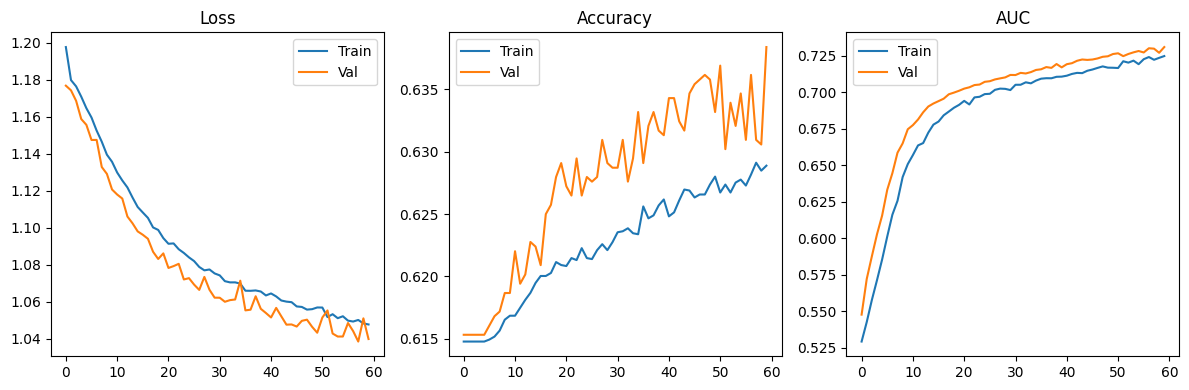

In [7]:
# =====================
# TESTING
# =====================
model.load_state_dict(torch.load(config["model_path_auc"]))
model.eval()
test_loss, test_preds, test_labels, test_probs = 0, [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        loss = criterion(preds, labels)
        test_loss += loss.item()
        probs = torch.softmax(preds, dim=1)
        test_preds.extend(torch.argmax(preds, 1).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

test_loss /= len(test_loader)
test_acc, test_prec, test_rec, test_f1, test_auc = compute_metrics(test_labels, test_preds, test_probs)

# Specificity (macro-averaged)
cm = confusion_matrix(test_labels, test_preds)
tn = cm.sum() - (cm.sum(axis=1) + cm.sum(axis=0) - np.diag(cm))
fp = cm.sum(axis=0) - np.diag(cm)
specificity = np.mean(tn / (tn + fp + 1e-8))

print("\n=== Test Results ===")
print(f" Loss={test_loss:.4f}, Acc={test_acc:.4f}, Prec={test_prec:.4f}, "
      f"Rec={test_rec:.4f}, F1={test_f1:.4f}, AUC={test_auc:.4f}, Spec={specificity:.4f}")

# Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_data.classes, yticklabels=test_data.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.close()

# =====================
# FINAL SUMMARY PLOT
# =====================
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history["train_loss"], label="Train")
plt.plot(history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history["train_acc"], label="Train")
plt.plot(history["val_acc"], label="Val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history["train_auc"], label="Train")
plt.plot(history["val_auc"], label="Val")
plt.title("AUC")
plt.legend()

plt.tight_layout()
plt.savefig("summary.png")
plt.show()